In [51]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Config

In [52]:
variant = 6

## Read data

In [53]:
data_dir = 'rawData'

x = None
A = None

for file in os.listdir(data_dir):
  full_file_path = os.path.join(data_dir, file)

  if not os.path.isfile(full_file_path):
    continue

  with open(full_file_path, 'r') as f:
    data = f.read().strip().splitlines()
    data_columns = [line.split(' ') for line in data]
    df = pd.DataFrame(data_columns)

    if x is None:
      x = df[0].to_numpy().astype(float)

    if A is None:
      A = df[variant].to_numpy().astype(float)
    else:
      A = np.vstack((A, df[variant].to_numpy().astype(float)))

x.shape, A.shape

((1024,), (55, 1024))

In [54]:
A

array([[6945., 7010., 7023., ..., 7037., 6929., 6942.],
       [ 498.,  646.,  633., ...,  364.,  468.,  588.],
       [1990., 3641., 2157., ..., 1950., 1946., 2210.],
       ...,
       [ 423.,  474.,  686., ...,  117.,  448.,  258.],
       [1979., 2059., 2201., ..., 1798., 1953., 1859.],
       [5157., 5519., 5450., ..., 5146., 5412., 5436.]])

In [55]:
y = A.mean(axis=0)
y.shape

(1024,)

## Visualization

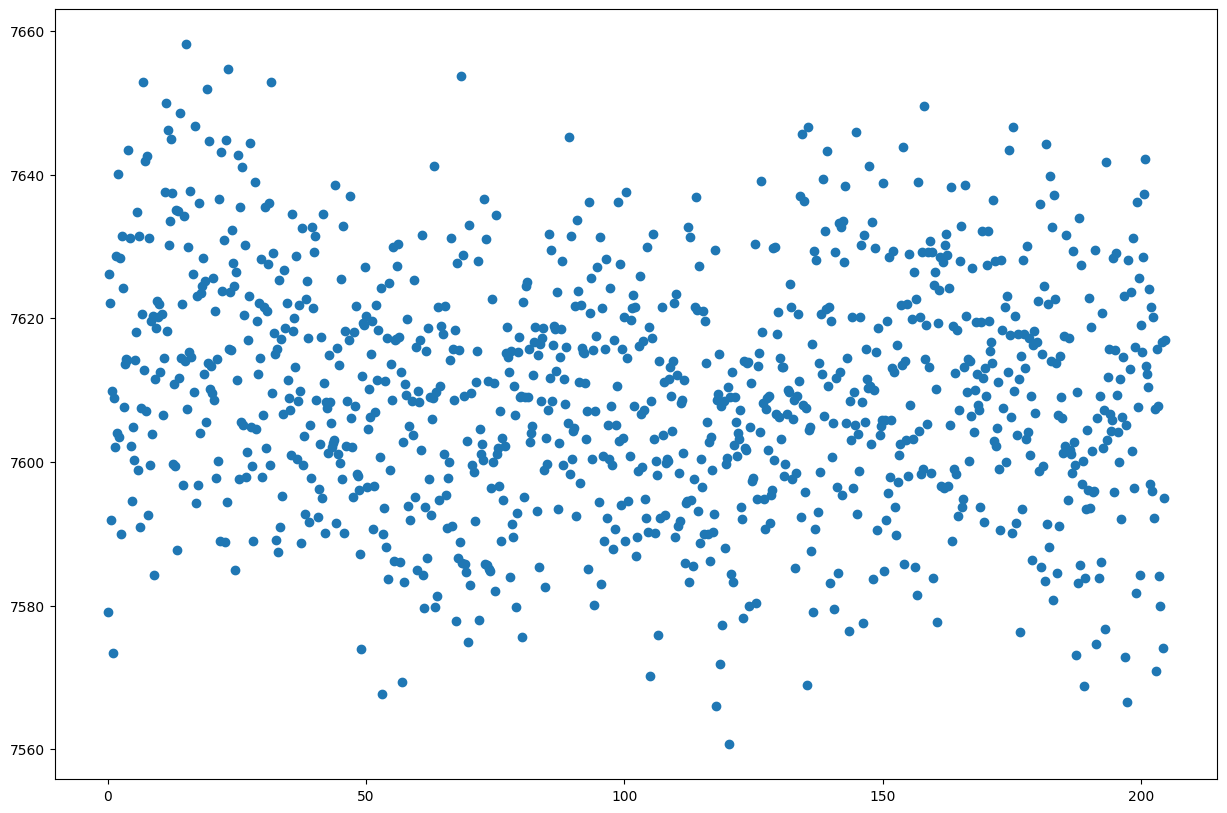

In [56]:
figure, axis = plt.subplots(1, 1, figsize=(15, 10))
plt.scatter(x, y)